# S&P500 Price Trend Comparison and Analysis

Name: Stefani Sindarto

Goal: This assignment will allow you to apply your knowledge of machine learning that you have aquired in this course on a real-world dataset of your choosing per the assignment specifications.

## Problem


• Analyzing the S&P500 Stock Trend from 2013 to the present.

## Data


• Source: https://www.wsj.com/market-data/quotes/index/SPX/historical-prices

• About the dataset:
    The data shows historical price data for the S&P 500 index.



In [1752]:
def parse_csv(line):
    '''splits each line by comma'''
    return line.strip().split(',')

def load_data(path, parsefn):
    '''reads file at PATH and applies PARSEFN to each line'''
    with open(path) as file:
        return [parsefn(line) for line in file]

sp = load_data('HistoricalPrices.csv', parse_csv)

heading, data = sp[0], sp[1:]
print(data[:5])
print(heading)



[['04/04/23', ' 4128.03', ' 4133.13', ' 4086.87', ' 4100.60'], ['04/03/23', ' 4102.20', ' 4127.66', ' 4098.79', ' 4124.51'], ['03/31/23', ' 4056.18', ' 4110.75', ' 4056.18', ' 4109.31'], ['03/30/23', ' 4046.74', ' 4057.85', ' 4032.10', ' 4050.83'], ['03/29/23', ' 3999.53', ' 4030.59', ' 3999.53', ' 4027.81']]
['Date', ' Open', ' High', ' Low', ' Close']


## Cleaning the Data

Add the code to download/query you data. If your data is already downloaded, then load it into your program here. Then add the code to clean it.

In [1753]:
import itertools
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from datetime import datetime
from collections import defaultdict
from sklearn.preprocessing import normalize
from sklearn.linear_model import BayesianRidge
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV


print(len(data))

2582


Convert prices into float from string.

In [1754]:
for d in data:
    converted_dates = datetime.strptime(d[0], '%m/%d/%y')
    d[0]= converted_dates
    d[1] = float(d[1])
    d[2] = float(d[2])
    d[3] = float(d[3])
    d[4] = float(d[4])
    d.append(converted_dates.month)
data[0]

[datetime.datetime(2023, 4, 4, 0, 0), 4128.03, 4133.13, 4086.87, 4100.6, 4]

Add a new column to include day 1 data by comparing today's opening price to previous day's closing price.

In [1755]:
for i in range(length):
    if i+1 < length:
        if(data[i][1]>data[i+1][4]):
            trend = 1
        elif (data[i][1]<data[i+1][4]):
            trend = -1
        else:
            trend=0
    else:
        trend = None

    data[i].append(trend)

Add a new column to include day 1 data by comparing closing price.

In [1756]:
length = len(data)

for i in range(length):
    if i+1 < length:
        if(data[i][4]>data[i+1][4]):
            trend = 1
        elif (data[i][4]<data[i+1][4]):
            trend = -1
        else:
            trend=0
    else:
        trend = None

    data[i].append(trend)

data[0]

[datetime.datetime(2023, 4, 4, 0, 0),
 4128.03,
 4133.13,
 4086.87,
 4100.6,
 4,
 1,
 -1]

Add a new column to shift the trend data upwards to reflect the trend two days prior.

In [1757]:
for i in range(length-1):
    offset = 1
    if i+offset < length:
        data[i].append(data[i+offset][7])

data[0]


[datetime.datetime(2023, 4, 4, 0, 0),
 4128.03,
 4133.13,
 4086.87,
 4100.6,
 4,
 1,
 -1,
 1]

Add a new column to shift the trend data upwards to reflect the trend three days prior.

In [1758]:
for i in range(length-2):
    data[i].append(data[i+1][8])

data[0]

[datetime.datetime(2023, 4, 4, 0, 0),
 4128.03,
 4133.13,
 4086.87,
 4100.6,
 4,
 1,
 -1,
 1,
 1]

Add a new column to shift the trend data upwards to reflect the trend four days prior.

In [1759]:
for i in range(length-3):
    data[i].append(data[i+1][9])

data[0]

[datetime.datetime(2023, 4, 4, 0, 0),
 4128.03,
 4133.13,
 4086.87,
 4100.6,
 4,
 1,
 -1,
 1,
 1,
 1]

Add a new column to shift the trend data upwards to reflect the trend five days prior.

In [1760]:
for i in range(length-4):
    data[i].append(data[i+1][10])

data[0]

[datetime.datetime(2023, 4, 4, 0, 0),
 4128.03,
 4133.13,
 4086.87,
 4100.6,
 4,
 1,
 -1,
 1,
 1,
 1,
 1]

Add a new column to shift the trend data upwards to reflect the trend six days prior.

In [1761]:
for i in range(length-5):
    data[i].append(data[i+1][11])


data[0]

[datetime.datetime(2023, 4, 4, 0, 0),
 4128.03,
 4133.13,
 4086.87,
 4100.6,
 4,
 1,
 -1,
 1,
 1,
 1,
 1,
 -1]

Remove the last 5 rows with empty values.

In [1762]:
for i in range(6):
    data.pop()

data[0]

[datetime.datetime(2023, 4, 4, 0, 0),
 4128.03,
 4133.13,
 4086.87,
 4100.6,
 4,
 1,
 -1,
 1,
 1,
 1,
 1,
 -1]

Create a hashmap of yearly data.

In [1763]:
yearly_data = defaultdict(list)
for d in data:
        yearly_data[d[0].year].append(d)


## Learning Model

In [1764]:
data = np.array(data)
X, y = data[:,[1,2,3,4,5,6,8,9,10,11]], data[:, 7]

Splitting the data into testing and training set.

In [1765]:
X_train, X_test, y_train, y_test = \
    train_test_split(X, y, test_size=0.3, random_state=217)

print("Shape of X_train:", X_train.shape)
print("Shape of X_test:", X_test.shape)
print("Shape of y_train:", y_train.shape)
print("Shape of y_test:", y_test.shape)

Shape of X_train: (1803, 10)
Shape of X_test: (773, 10)
Shape of y_train: (1803,)
Shape of y_test: (773,)


Bayesian Ridge Regression

In [1775]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

model = BayesianRidge()

model.fit(X_train, y_train)


scores = cross_val_score(model, X_train, y_train, cv=5)
print("Cross-validation scores:", scores)
print("Mean cross-validation score:", np.mean(scores))

test_score = model.score(X_test, y_test)
print("Test score:", test_score)



Cross-validation scores: [0.47365953 0.41423962 0.464768   0.43176621 0.42567937]
Mean cross-validation score: 0.4420225451608906
Test score: 0.4830507108160538


In [1767]:
model = LinearRegression()

model.fit(X_train, y_train)


scores = cross_val_score(model, X_train, y_train, cv=5)
print("Cross-validation scores:", scores)
print("Mean cross-validation score:", np.mean(scores))

test_score = model.score(X_test, y_test)
print("Test score:", test_score)

Cross-validation scores: [0.37961041 0.48198092 0.41202988 0.4147666  0.44637868]
Mean cross-validation score: 0.42695329891528055
Test score: 0.4778651013138572


## Tuning and Feature Extraction


In [1776]:
X, y = data[:,[1,2,3,4,5,6,8]], data[:, 7]

X_train, X_test, y_train, y_test = \
    train_test_split(X, y, test_size=0.1, random_state=217)

print("Shape of X_train:", X_train.shape)
print("Shape of X_test:", X_test.shape)
print("Shape of y_train:", y_train.shape)
print("Shape of y_test:", y_test.shape)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

model = LinearRegression()

model.fit(X_train, y_train)


scores = cross_val_score(model, X_train, y_train, cv=5)
print("Cross-validation scores:", scores)
print("Mean cross-validation score:", np.mean(scores))

test_score = model.score(X_test, y_test)
print("Test score:", test_score)

Shape of X_train: (2318, 7)
Shape of X_test: (258, 7)
Shape of y_train: (2318,)
Shape of y_test: (258,)
Cross-validation scores: [0.47472925 0.41413887 0.46504816 0.4319522  0.42469544]
Mean cross-validation score: 0.44211278342593285
Test score: 0.4830481411088109


## Visuals

Below, generate the visuals that will explain the results you are getting and show what you hoped to learn from the data.

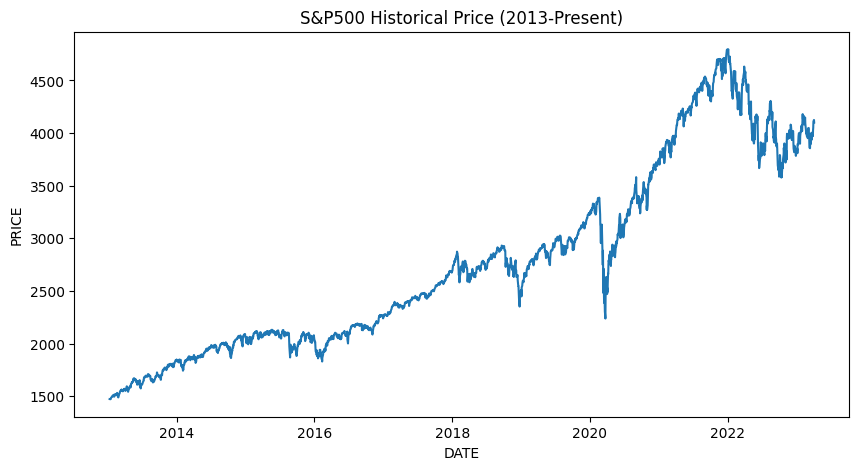

In [1592]:
dates = data[:, 0]
price = data[:, 4]

fig, ax = plt.subplots()
fig.set_size_inches(10, 5)
ax.set(xlabel='DATE', ylabel='PRICE',
       title='S&P500 Historical Price (2013-Present)')
ax.plot(dates, price)
plt.savefig("historicalprices.png")
plt.show()


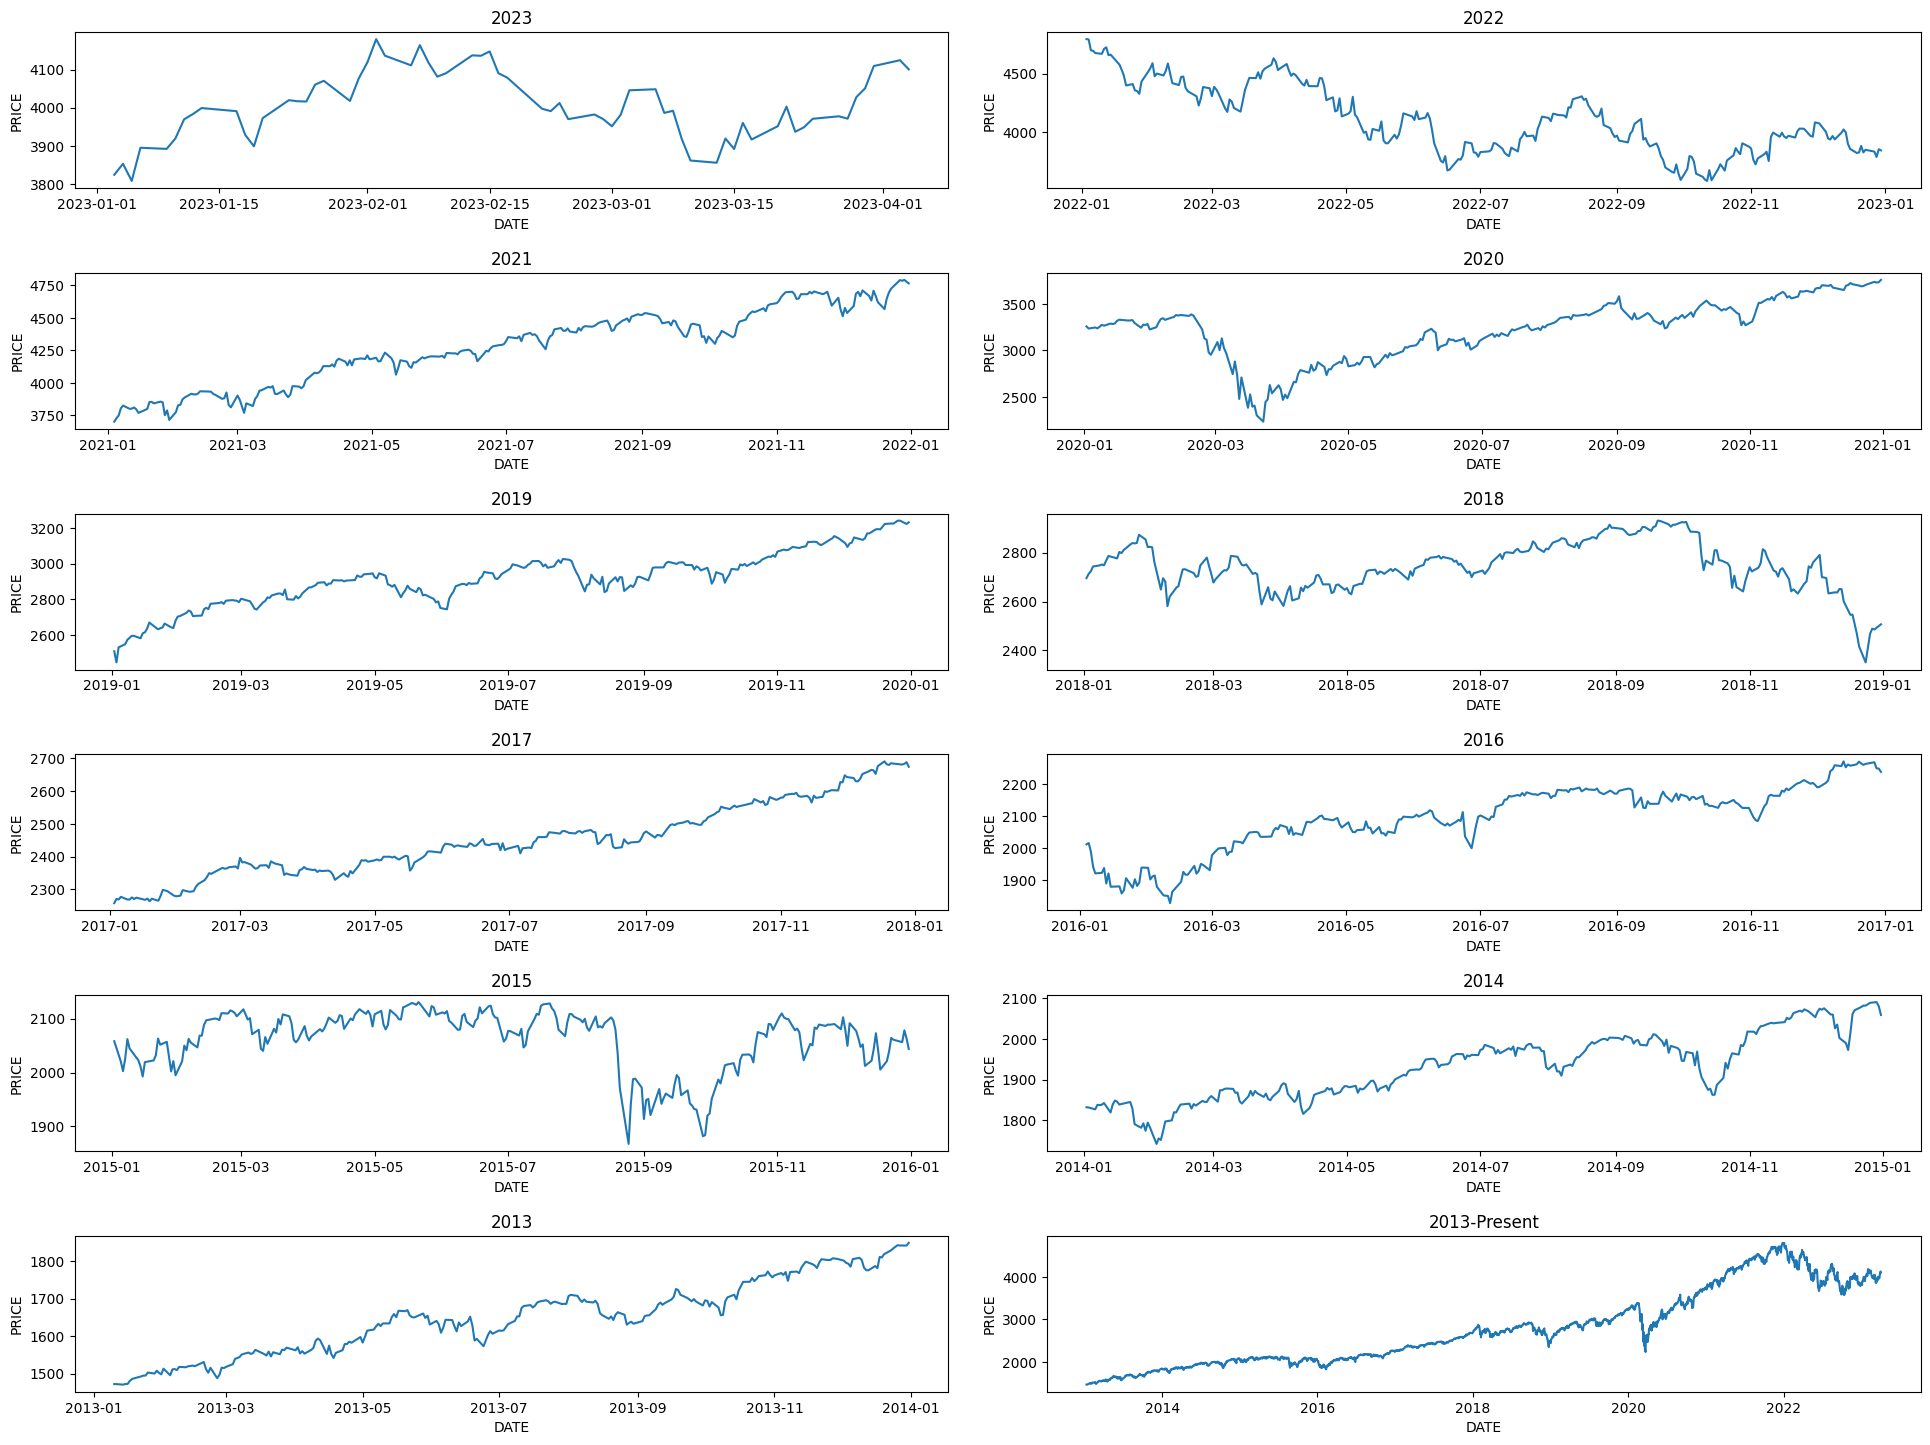

In [1591]:
data = np.array(data)
data_23 = np.array(yearly_data[2023])
data_22 = np.array(yearly_data[2022])
data_21 = np.array(yearly_data[2021])
data_20 = np.array(yearly_data[2020])
data_19 = np.array(yearly_data[2019])
data_18 = np.array(yearly_data[2018])
data_17 = np.array(yearly_data[2017])
data_16 = np.array(yearly_data[2016])
data_15 = np.array(yearly_data[2015])
data_14 = np.array(yearly_data[2014])
data_13 = np.array(yearly_data[2013])


dates_23 = data_23[:, 0]
price_23 = data_23[:, 4]
dates_22 = data_22[:, 0]
price_22 = data_22[:, 4]
dates_21 = data_21[:, 0]
price_21 = data_21[:, 4]
dates_20 = data_20[:, 0]
price_20 = data_20[:, 4]
dates_19 = data_19[:, 0]
price_19 = data_19[:, 4]
dates_18 = data_18[:, 0]
price_18 = data_18[:, 4]
dates_17 = data_17[:, 0]
price_17 = data_17[:, 4]
dates_16 = data_16[:, 0]
price_16 = data_16[:, 4]
dates_15 = data_15[:, 0]
price_15 = data_15[:, 4]
dates_14 = data_14[:, 0]
price_14 = data_14[:, 4]
dates_13 = data_13[:, 0]
price_13 = data_13[:, 4]
dates = data[:, 0]
price = data[:, 4]

fig, ax = plt.subplots(6,2)
fig.set_size_inches(20, 15)
fig.tight_layout(pad=4.0)
ax[0,0].set(xlabel='DATE', ylabel='PRICE',
       title='2023')
ax[0,0].plot(dates_23, price_23)
ax[0,1].set(xlabel='DATE', ylabel='PRICE',
       title='2022')
ax[0,1].plot(dates_22, price_22)
ax[1,0].set(xlabel='DATE', ylabel='PRICE',
       title='2021')
ax[1,0].plot(dates_21, price_21)
ax[1,1].set(xlabel='DATE', ylabel='PRICE',
       title='2020')
ax[1,1].plot(dates_20, price_20)
ax[2,0].set(xlabel='DATE', ylabel='PRICE',
       title='2019')
ax[2,0].plot(dates_19, price_19)
ax[2,1].set(xlabel='DATE', ylabel='PRICE',
       title='2018')
ax[2,1].plot(dates_18, price_18)
ax[3,0].set(xlabel='DATE', ylabel='PRICE',
       title='2017')
ax[3,0].plot(dates_17, price_17)
ax[3,1].set(xlabel='DATE', ylabel='PRICE',
       title='2016')
ax[3,1].plot(dates_16, price_16)
ax[4,0].set(xlabel='DATE', ylabel='PRICE',
       title='2015')
ax[4,0].plot(dates_15, price_15)
ax[4,1].set(xlabel='DATE', ylabel='PRICE',
       title='2014')
ax[4,1].plot(dates_14, price_14)
ax[5,0].set(xlabel='DATE', ylabel='PRICE',
       title='2013')
ax[5,0].plot(dates_13, price_13)
ax[5,1].set(xlabel='DATE', ylabel='PRICE',
       title='2013-Present')
ax[5,1].plot(dates, price)


plt.savefig("yearlydata.png")
plt.show()

## Reflection

• What features did you use in your final model and why were others excluded?

The final model included only the closing stock comparison trend of the previous day along with the opening, high, low,  price. 
I found that the more days I include, the lower the accuracy is.
It seems that the other features do not have a strong correlation with the target variable or did not improve the accuracy of the model.

• Which ML methods did you use and why? Which performed best before you started tuning? Did things change after tuning?

Two machine learning methods were used for the analysis: Linear Regression and Bayesian Ridge Regression. 
Linear regression was selected because it is a simple and commonly used method for regression analysis. Bayesian Ridge Regression was selected because it can handle multicollinearity and is less sensitive to outliers than linear regression. 

• What was the accuracy before and then after cross validation?

After performing cross-validation below,
scores = cross_val_score(model, X_train, y_train, cv=5)

I obtained the scores:
Cross-validation scores: [0.47472925 0.41413887 0.46504816 0.4319522  0.42469544]
Mean cross-validation score: 0.44211278342593285

This is lower than my actual test score below.
Test score: 0.4830481411088109
